In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models


## 配置gpu使用，防止gpu内存不够用报错
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

E:\Anaconda5.2\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda5.2\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda5.2\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda5.2\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

In [2]:
FILE_PATH = './dog-cat-full-dataset-master/data/train/'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
datagen = ImageDataGenerator(rescale=1/255.)

In [5]:
train_genertator = datagen.flow_from_directory(FILE_PATH, target_size=(224, 224), 
                                              classes=['dogs', 'cats'],
                                              class_mode='binary',
                                              batch_size=20)

Found 20000 images belonging to 2 classes.


In [6]:
validation_generator = datagen.flow_from_directory(directory='./dog-cat-full-dataset-master/data/test/', target_size=(224, 224),
                                                  classes=['dogs', 'cats'],
                                                  class_mode='binary',
                                                  batch_size=20)

Found 5000 images belonging to 2 classes.


In [7]:
def train_classifer(train_generator, valid_generator, outModelFileName):
    conv_base = VGG16(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    conv_base.trainable = False
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [8]:
model = train_classifer(train_genertator, validation_generator, outModelFileName='./')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
history = model.fit_generator(generator=train_genertator, steps_per_epoch=len(train_genertator), epochs=5, validation_data=validation_generator, validation_steps=len(validation_generator), verbose=1)

Epoch 1/5
1000/1000 [==============================] - 359s 359ms/step - loss: 0.2319 - accuracy: 0.9033 - val_loss: 0.1725 - val_accuracy: 0.9310
Epoch 2/5
1000/1000 [==============================] - 176s 176ms/step - loss: 0.1324 - accuracy: 0.9470 - val_loss: 0.2147 - val_accuracy: 0.9142
Epoch 3/5
1000/1000 [==============================] - 177s 177ms/step - loss: 0.0997 - accuracy: 0.9610 - val_loss: 0.1735 - val_accuracy: 0.9292
Epoch 4/5
1000/1000 [==============================] - 180s 180ms/step - loss: 0.0809 - accuracy: 0.9676 - val_loss: 0.1789 - val_accuracy: 0.9334
Epoch 5/5
1000/1000 [==============================] - 184s 184ms/step - loss: 0.0626 - accuracy: 0.9769 - val_loss: 0.2071 - val_accuracy: 0.9276


In [11]:
def plot_learningCureve(history):
    epoch_range = range(1, 6)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

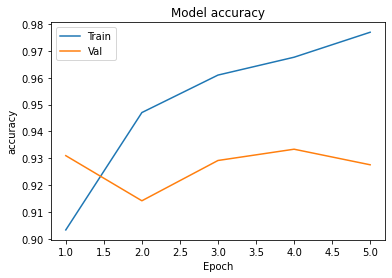

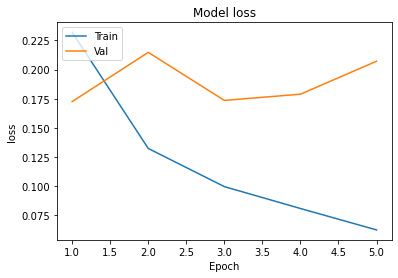

In [12]:
plot_learningCureve(history)

In [13]:
test_loss, test_acc = model.evaluate_generator(validation_generator, verbose=1)
print(test_loss, test_acc)

250/250 [==============================] - 35s 141ms/step - loss: 0.2071 - accuracy: 0.9276
0.20707765778014436 0.9276


## 保存模型

In [14]:
logdir = os.path.join('graph_def_and_weights')
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 'vgg16qianyi.h5')
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True,
                                    save_weights_only = False),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),]
history = model.fit_generator(generator=train_genertator, steps_per_epoch=len(train_genertator), epochs=5, validation_data=validation_generator, validation_steps=len(validation_generator), verbose=1,callbacks=callbacks)


Epoch 1/5
1000/1000 [==============================] - 181s 181ms/step - loss: 0.0501 - accuracy: 0.9826 - val_loss: 0.2456 - val_accuracy: 0.9228
Epoch 2/5
1000/1000 [==============================] - 182s 182ms/step - loss: 0.0429 - accuracy: 0.9861 - val_loss: 0.2082 - val_accuracy: 0.9290
Epoch 3/5
1000/1000 [==============================] - 182s 182ms/step - loss: 0.0317 - accuracy: 0.9898 - val_loss: 0.2725 - val_accuracy: 0.9158
Epoch 4/5
1000/1000 [==============================] - 178s 178ms/step - loss: 0.0328 - accuracy: 0.9883 - val_loss: 0.2440 - val_accuracy: 0.9236
Epoch 5/5
1000/1000 [==============================] - 179s 179ms/step - loss: 0.0196 - accuracy: 0.9953 - val_loss: 0.2853 - val_accuracy: 0.9192


In [15]:
model = load_model('./graph_def_and_weights/vgg16qianyi.h5')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 14,739,777
Non-trainable params: 0
_________________________________________________________________


In [17]:
ypred = model.predict_generator(validation_generator, verbose=1)

250/250 [==============================] - 41s 163ms/step


In [18]:
ypred = tf.argmax(ypred, axis=1).numpy()

In [19]:
y_test = validation_generator.classes

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x261f8349278>)

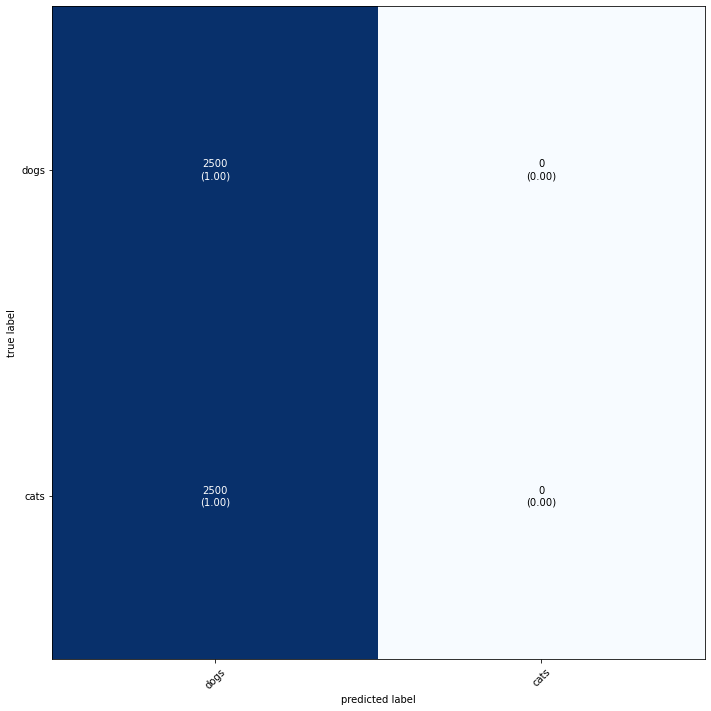

In [20]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, ypred)
plot_confusion_matrix(mat, class_names=['dogs', 'cats'], figsize=(12, 12), show_normed=True)